In [1]:
pip install termcolor

Note: you may need to restart the kernel to use updated packages.


In [105]:
#Main libraries inpython
import pandas as pd
import numpy as np

#This library to make the font 'bold'
from termcolor import colored as cl # elegant printing of text

# This libraries for ploting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import plot_confusion_matrix


sns.set_style('whitegrid') # just optional!
%matplotlib inline

#Setting display format to retina in matplotlib to see better quality images.
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# This libraries for modeling to select the best features
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# This libraries for modeling to predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

# library to calculate the error
from sklearn import metrics


# Lines below are just to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
#First we need to download the dataset and save it to dataframe
df=pd.read_csv('train.csv')

In [4]:
#Because the dataframe is too large ,so I cut it to be only 10,000 rows
df=df[:10000]

In [5]:
#Display the dataframe to see it
df.head(3)

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,...,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0


In [8]:
print(cl("The shape of dataset is:",attrs = ['bold']),df.shape)

The shape of dataset is: (10000, 83)


In [6]:
# check if there are null values in dataframe
df.isnull().sum()

MachineIdentifier                            0
ProductName                                  0
EngineVersion                                0
AppVersion                                   0
AvSigVersion                                 0
                                          ... 
Census_IsPenCapable                          0
Census_IsAlwaysOnAlwaysConnectedCapable     78
Wdft_IsGamer                               309
Wdft_RegionIdentifier                      309
HasDetections                                0
Length: 83, dtype: int64

In [9]:
#There are many columns have more than 25% null value, so it is better to remove these columns to pevent
#effect the predict badly
df.drop(labels=['DefaultBrowsersIdentifier', 'OrganizationIdentifier','PuaMode','SmartScreen'
                       ,'Census_ProcessorClass','Census_InternalBatteryType','Census_IsFlightingInternal'
                       ,'Census_ThresholdOptIn','Census_IsWIMBootEnabled'],axis='columns', inplace=True)

In [10]:
# Then, check the precentage of other columns and save it to dataframe
mis_val_percent = 100 * df.isnull().sum() / len(df)
mis_val_percent=mis_val_percent.to_frame()

In [11]:
# rename the column name
mis_val_percent.rename({0: 'percentage'}, axis=1, inplace=True)

In [13]:
#Display only columns have missing value
mis_val_percent=mis_val_percent[mis_val_percent['percentage']!=0.0]
mis_val_percent

,percentage
RtpStateBitfield,0.34
AVProductStatesIdentifier,0.30
AVProductsInstalled,0.30
AVProductsEnabled,0.30
CityIdentifier,3.83
IsProtected,0.30
SMode,6.09
IeVerIdentifier,0.75
Firewall,0.96
UacLuaenable,0.09


In [14]:
#divide features to categorical and nemoric
df_=df.copy()
cateogry_columns=df_.select_dtypes(include=['object']).columns.tolist()
integer_columns=df_.select_dtypes(include=['int64','float64']).columns.tolist()

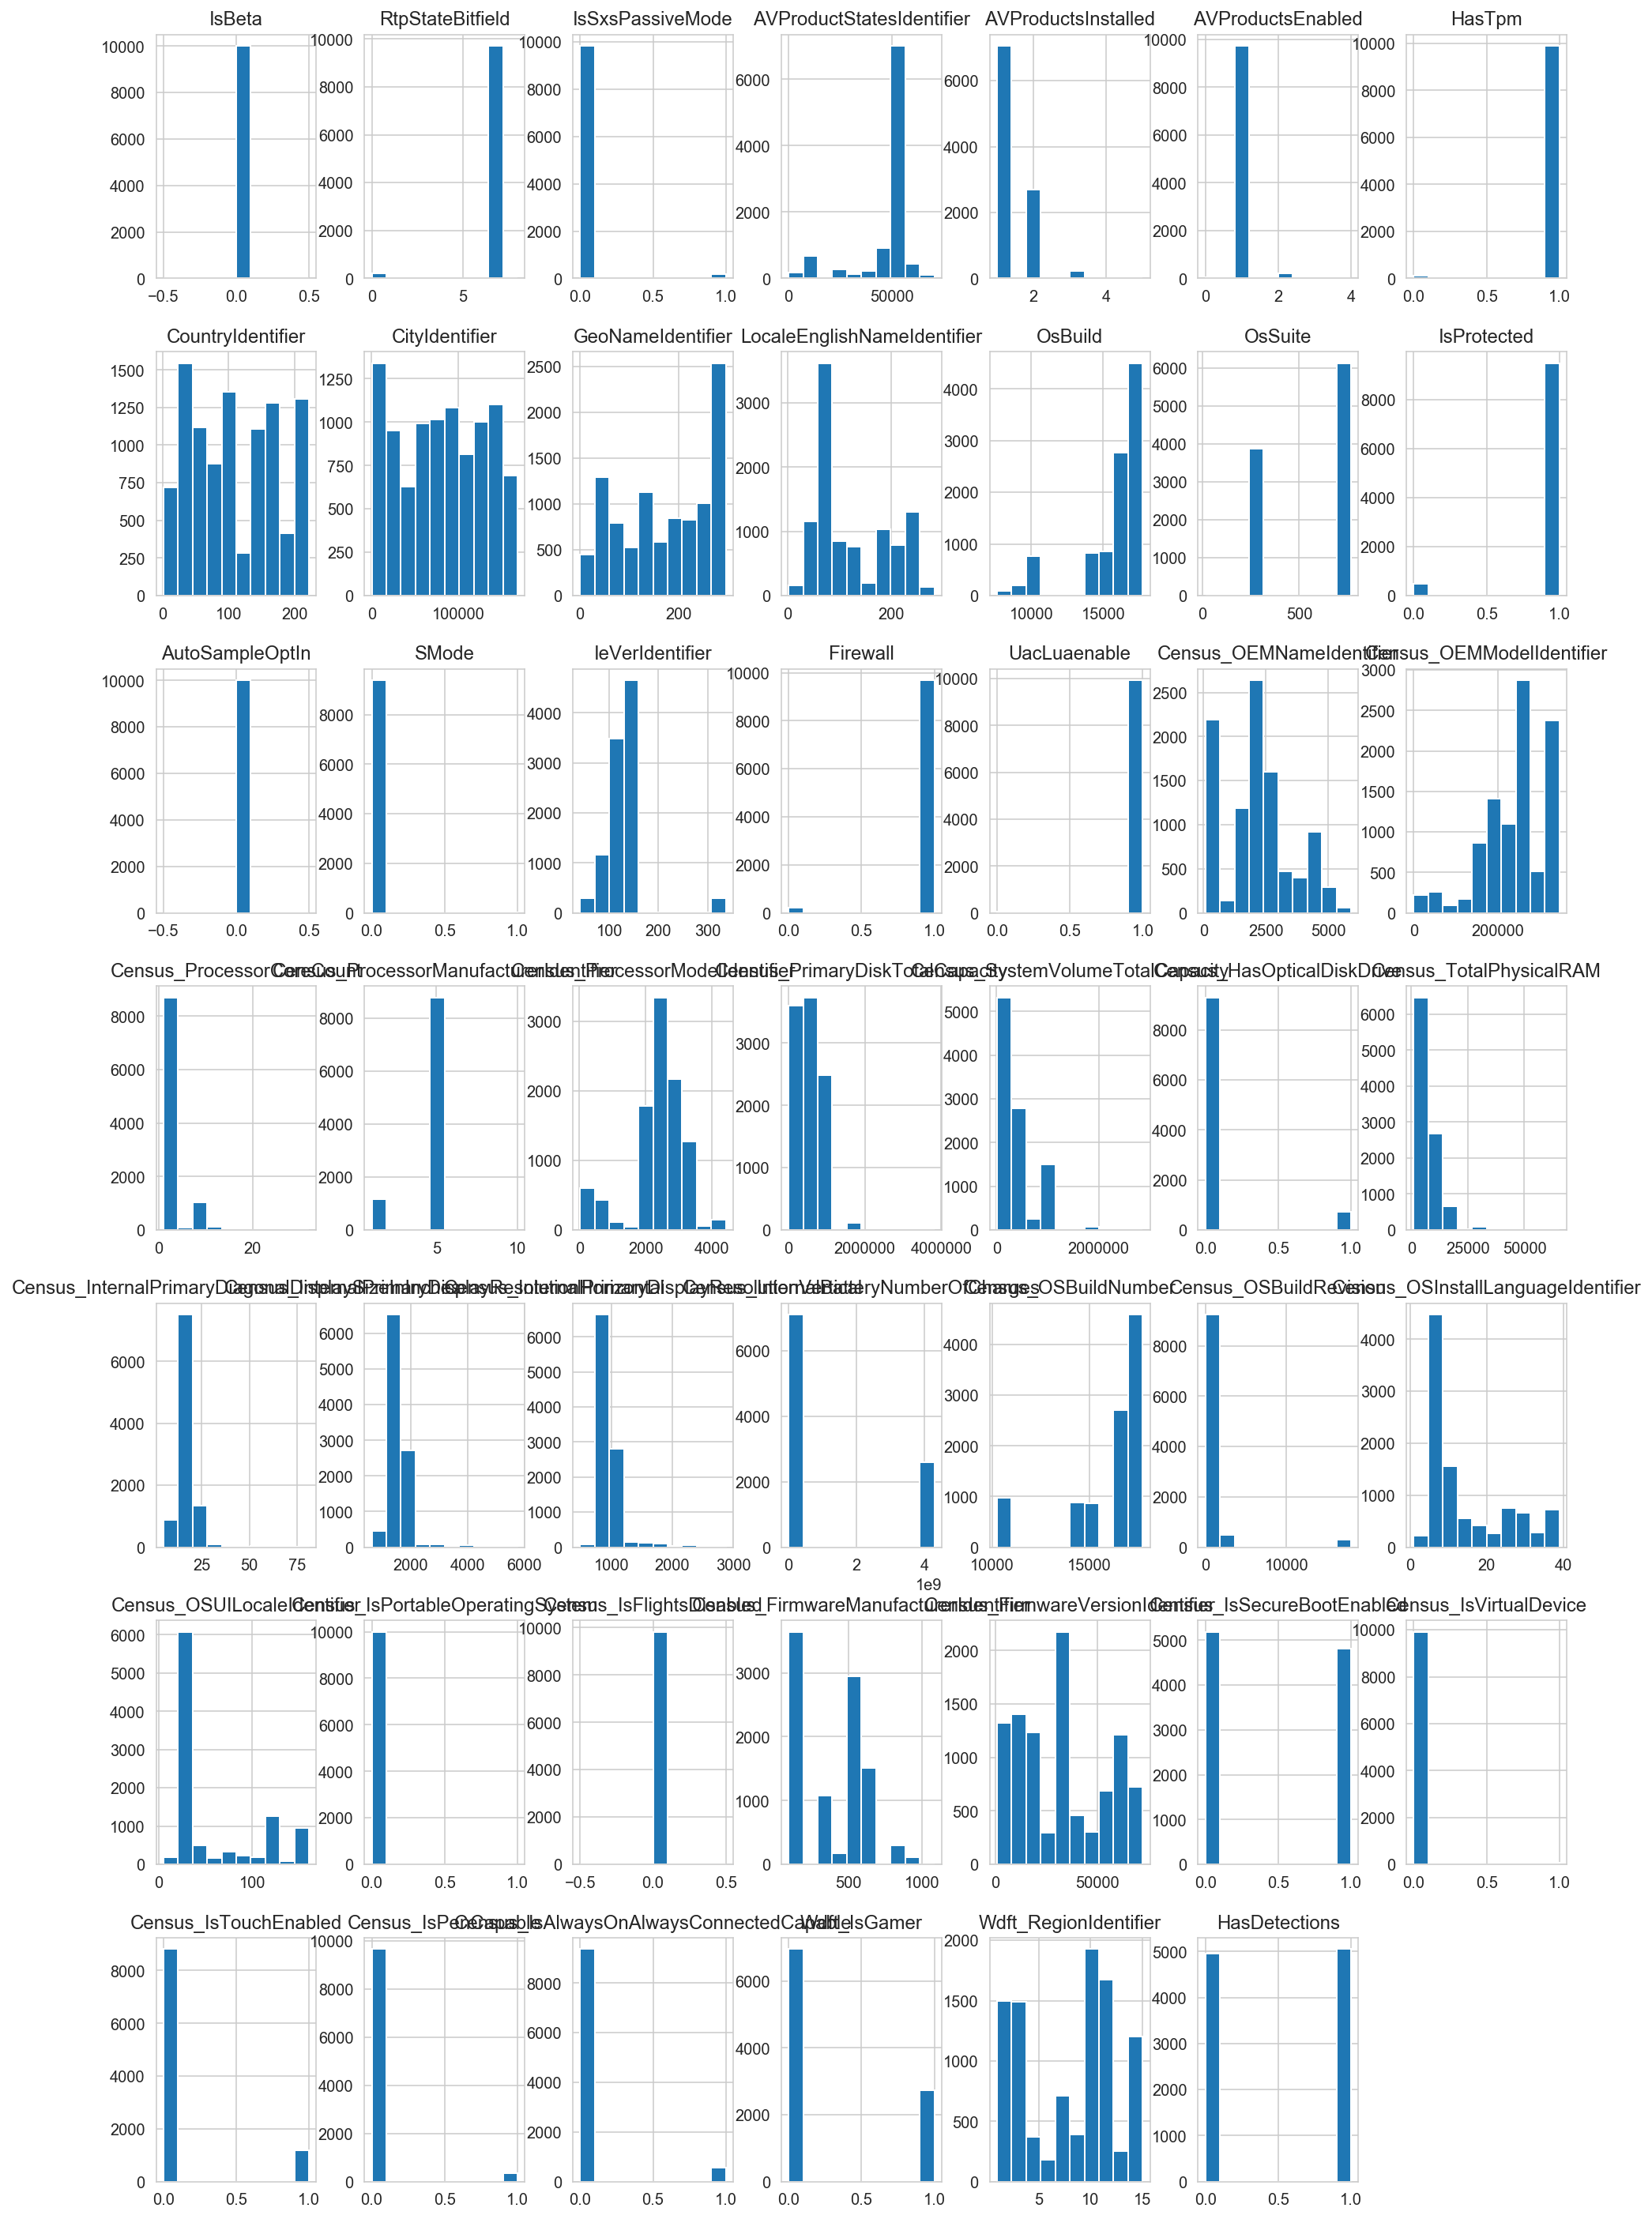

In [20]:
# See the distribution of integer value to select the best filling null value
df_.hist(column=integer_columns,figsize=(16,25))
plt.tight_layout()# make space between them

In [22]:
# Most of them have skew ,so it is better to use median rather than mean
# Add using get dummy to convert object columns

for column in df_.columns:
    if (df_[column].isnull().any()):
        if column in cateogry_columns:
            df_[column]=df_[column].replace(np.nan,0)
        else:
            df_[column]=df_[column].fillna(df_[column].median())
    if column in cateogry_columns:
        df_=pd.get_dummies(df_, columns=[column])

The shape of dataframe before cleansing:  (10000, 74)
The shape of dataframe after cleansing:  (10000, 12347)


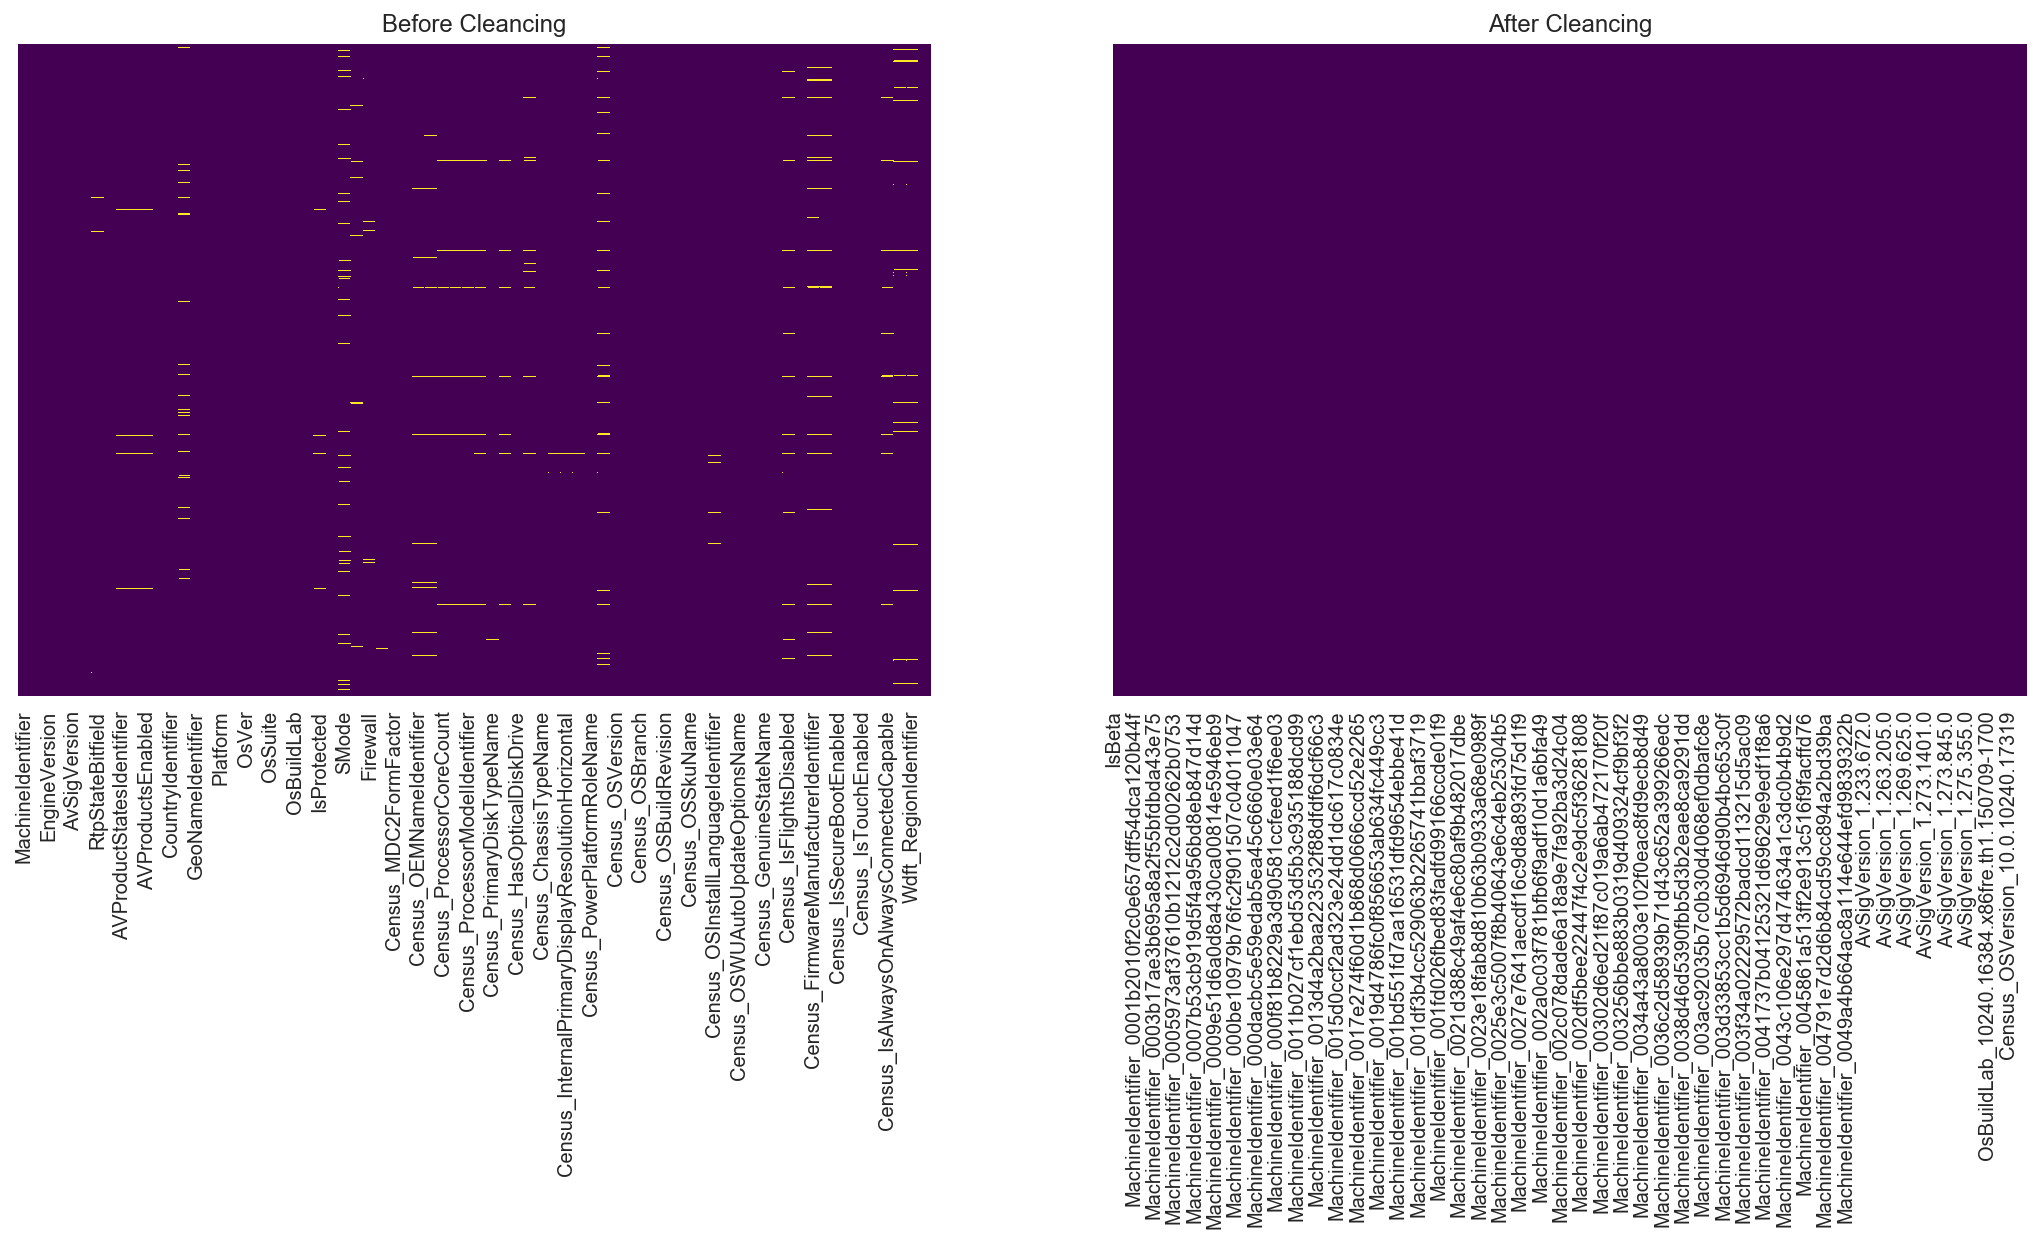

In [26]:
print ('The shape of dataframe before cleansing: ',df.shape)
print ('The shape of dataframe after cleansing: ',df_.shape)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
# train data 
sns.heatmap(df.isnull(), yticklabels=False, ax = ax[0], cbar=False, cmap='viridis')
ax[0].set_title('Before Cleancing')

# test data
sns.heatmap(df_.isnull(), yticklabels=False, ax = ax[1], cbar=False, cmap='viridis')
ax[1].set_title('After Cleancing');

 As you see, there is no nosiy in the second figer which means no missing value

### Filtering Features:

In [24]:
# sign all features without the taregt to X and save the target in y
X, y = df_.drop(columns=['HasDetections'],axis=1), df_[['HasDetections']]

In [28]:
#Do split 80% for training and 20% test
X_train,y_train,X_test,y_test = train_test_split(X,y,test_size=0.2)

#### Using feature_importances_

In [29]:
model = ExtraTreesClassifier()
model.fit(X, y)
dfscores = pd.DataFrame(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
feat_importances = pd.Series(model.feature_importances_, index=X.columns)


In [44]:
dfcolumns = pd.DataFrame(X.columns)# create dataframe that contains the columns' name
featureScores = pd.concat([dfcolumns,dfscores],axis=1)# connect the two dataframe togather to the nr=ew dataframe
featureScores.columns = ['features','feature_importances']  #naming the dataframe columns
featureScores=featureScores.nlargest(10,'feature_importances')  #print 10 best features
featureScores=featureScores.sort_values(by='feature_importances', ascending=True, inplace=False)# sort the values
featureScores# Display the dataframe that contains the impotance features with thier scores

,features,feature_importances
19,Census_OEMNameIdentifier,0.013553
3,AVProductStatesIdentifier,0.013682
10,LocaleEnglishNameIdentifier,0.014345
9,GeoNameIdentifier,0.014382
7,CountryIdentifier,0.014900
23,Census_ProcessorModelIdentifier,0.015295
39,Census_FirmwareVersionIdentifier,0.015480
8,CityIdentifier,0.015550
20,Census_OEMModelIdentifier,0.015765
25,Census_SystemVolumeTotalCapacity,0.015767


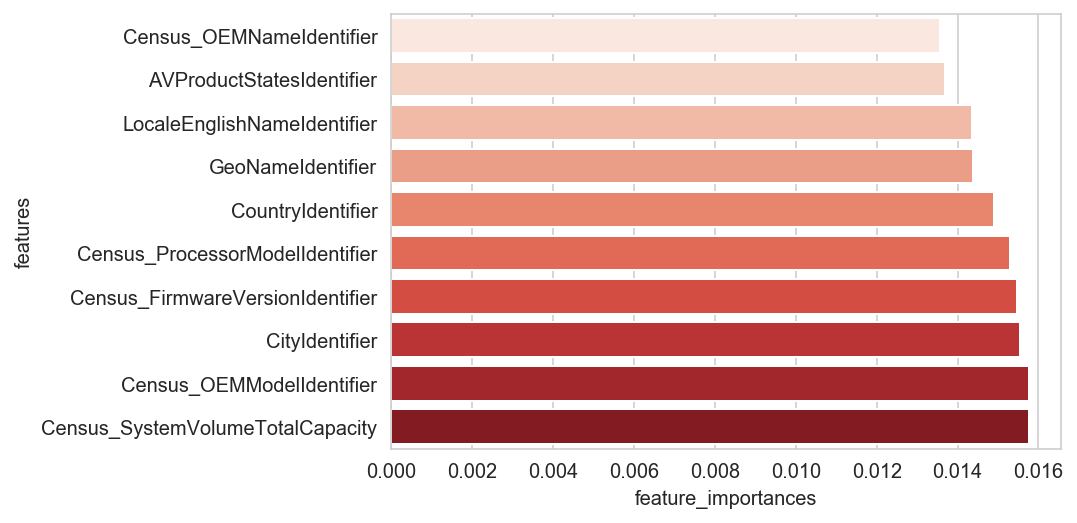

In [31]:
# plot the result
sns.barplot(x='feature_importances',y='features',data=featureScores,palette='Reds');


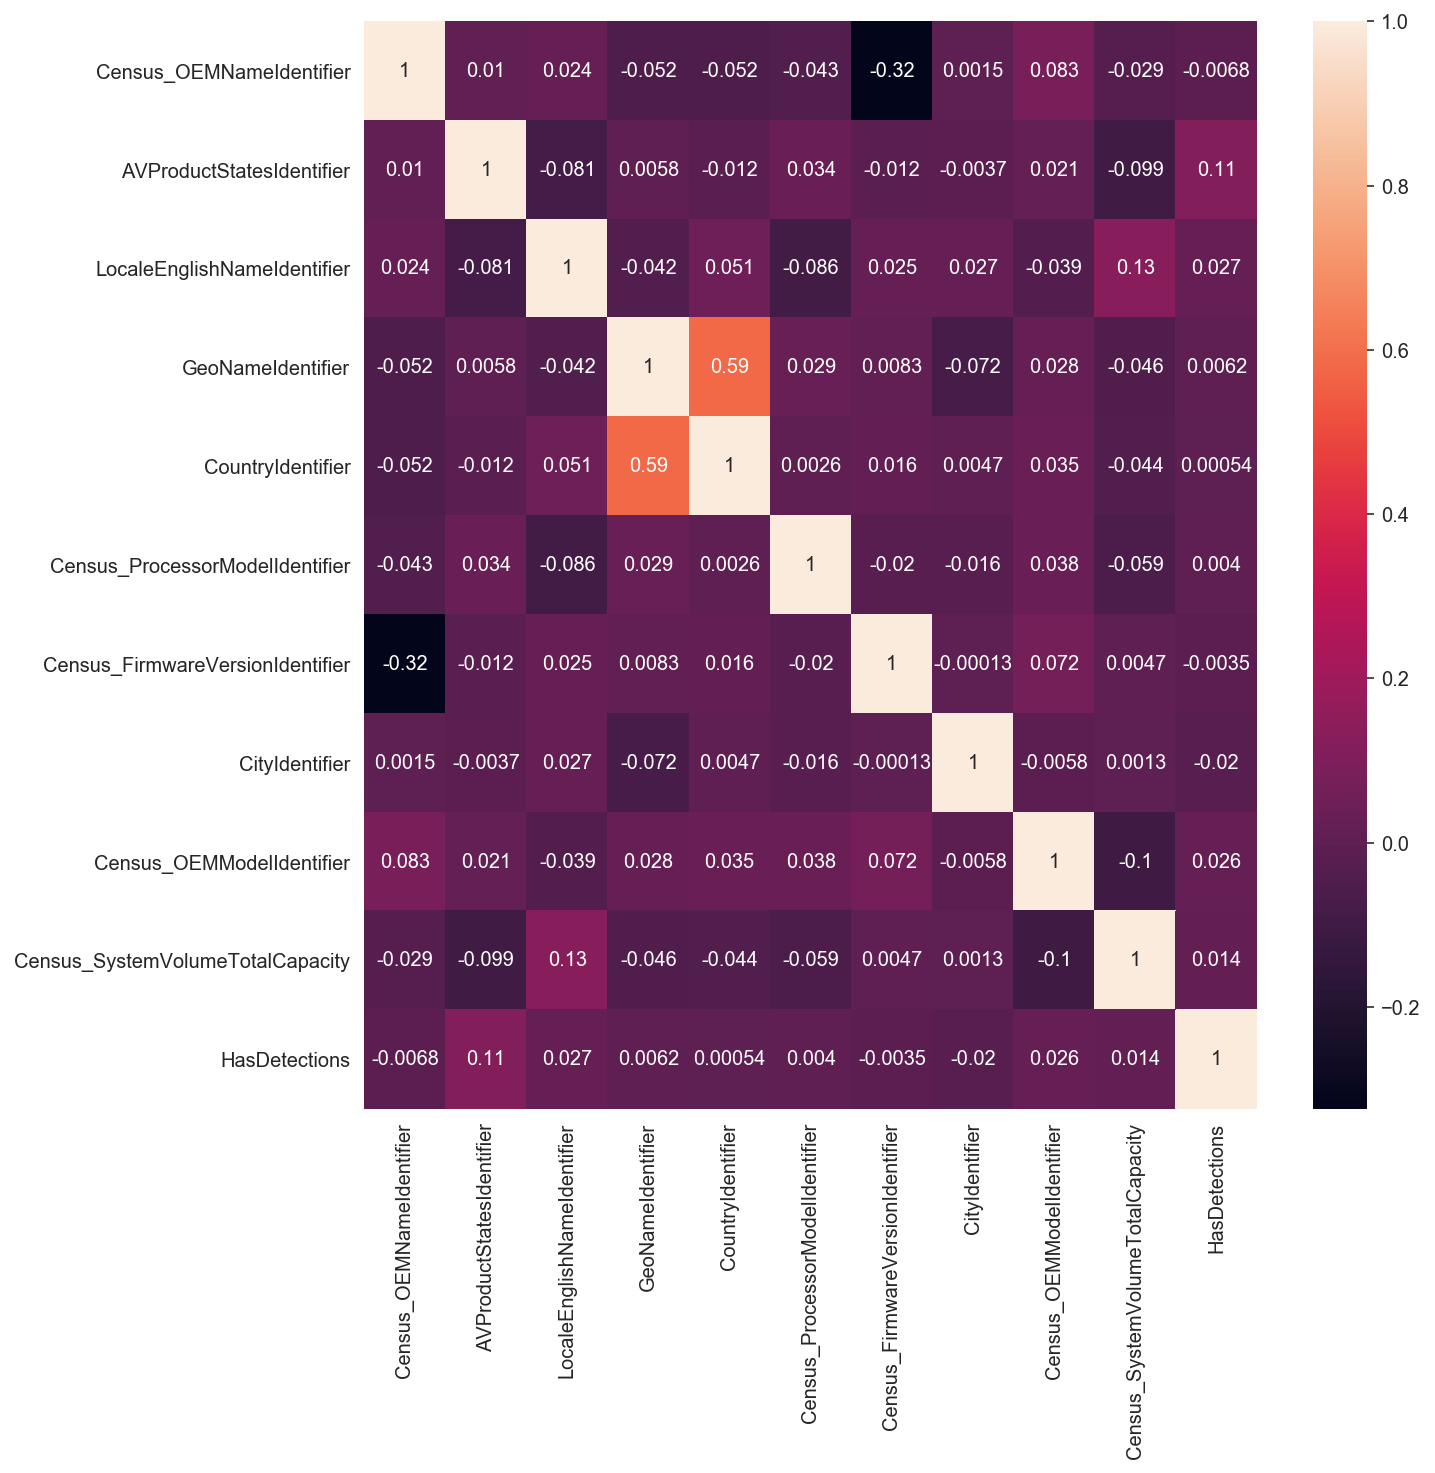

In [33]:
# plot heatmap to see the relationshipe between features and target
f_method=df_[featureScores['features']]
f_method['HasDetections']=df_['HasDetections']
plt.figure(figsize=(10,10))
sns.heatmap(f_method.corr(), annot=True);
plt.show()

Maybe this method is good but nearly half features have negative relationshipe with the target

#### - Using bestfeatures

In [43]:
X2, y = df_.drop(columns=['HasDetections'],axis=1), df_['HasDetections']
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit_2 = bestfeatures.fit(X2,y)
dfscores_2 = pd.DataFrame(fit_2.scores_)
dfcolumns_2 = pd.DataFrame(X2.columns)
#concat two dataframes for better visualization 
featureScores_2 = pd.concat([dfcolumns_2,dfscores_2],axis=1)
featureScores_2.columns = ['best_features','Score']  #naming the dataframe columns
featureScores_2=featureScores_2.nlargest(10,'Score')  #print 10 best features
featureScores_2
featureScores_2=featureScores_2.sort_values(by='Score', ascending=True, inplace=False)
featureScores_2# Display the dataframe that contains the best features with thier scores


,best_features,Score
32,Census_OSBuildNumber,1.265829e+03
39,Census_FirmwareVersionIdentifier,1.607952e+03
33,Census_OSBuildRevision,7.084929e+03
8,CityIdentifier,1.169582e+05
27,Census_TotalPhysicalRAM,1.206947e+05
20,Census_OEMModelIdentifier,1.492152e+05
3,AVProductStatesIdentifier,5.062320e+05
25,Census_SystemVolumeTotalCapacity,5.470687e+05
24,Census_PrimaryDiskTotalCapacity,7.078491e+06
31,Census_InternalBatteryNumberOfCharges,1.310997e+10


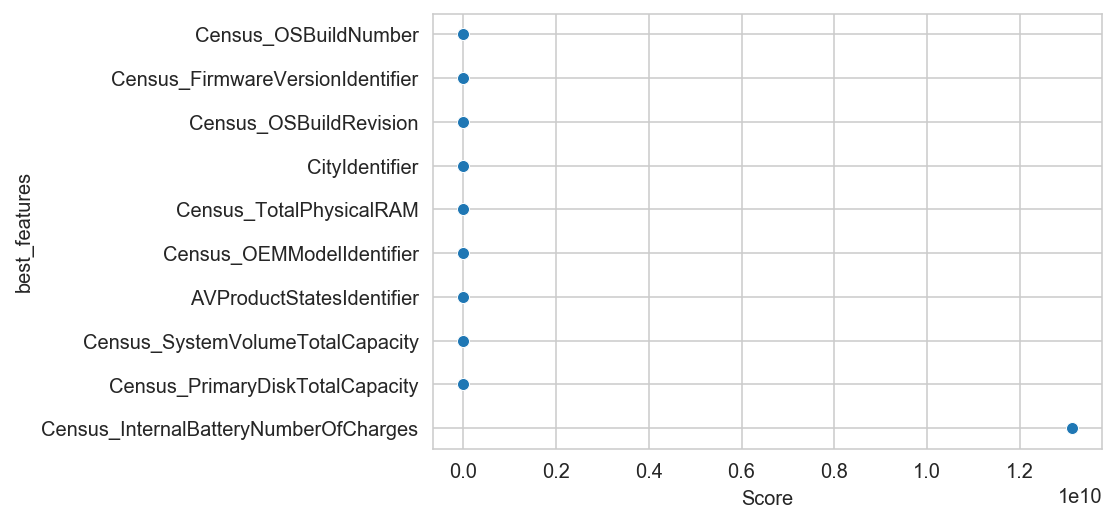

In [42]:
#plot the result 
sns.scatterplot(x='Score',y='best_features',data=featureScores_2,palette='Blues');


As you see, there are a big different between one feature with the rest, maybe this will affect on the peformance of prediction

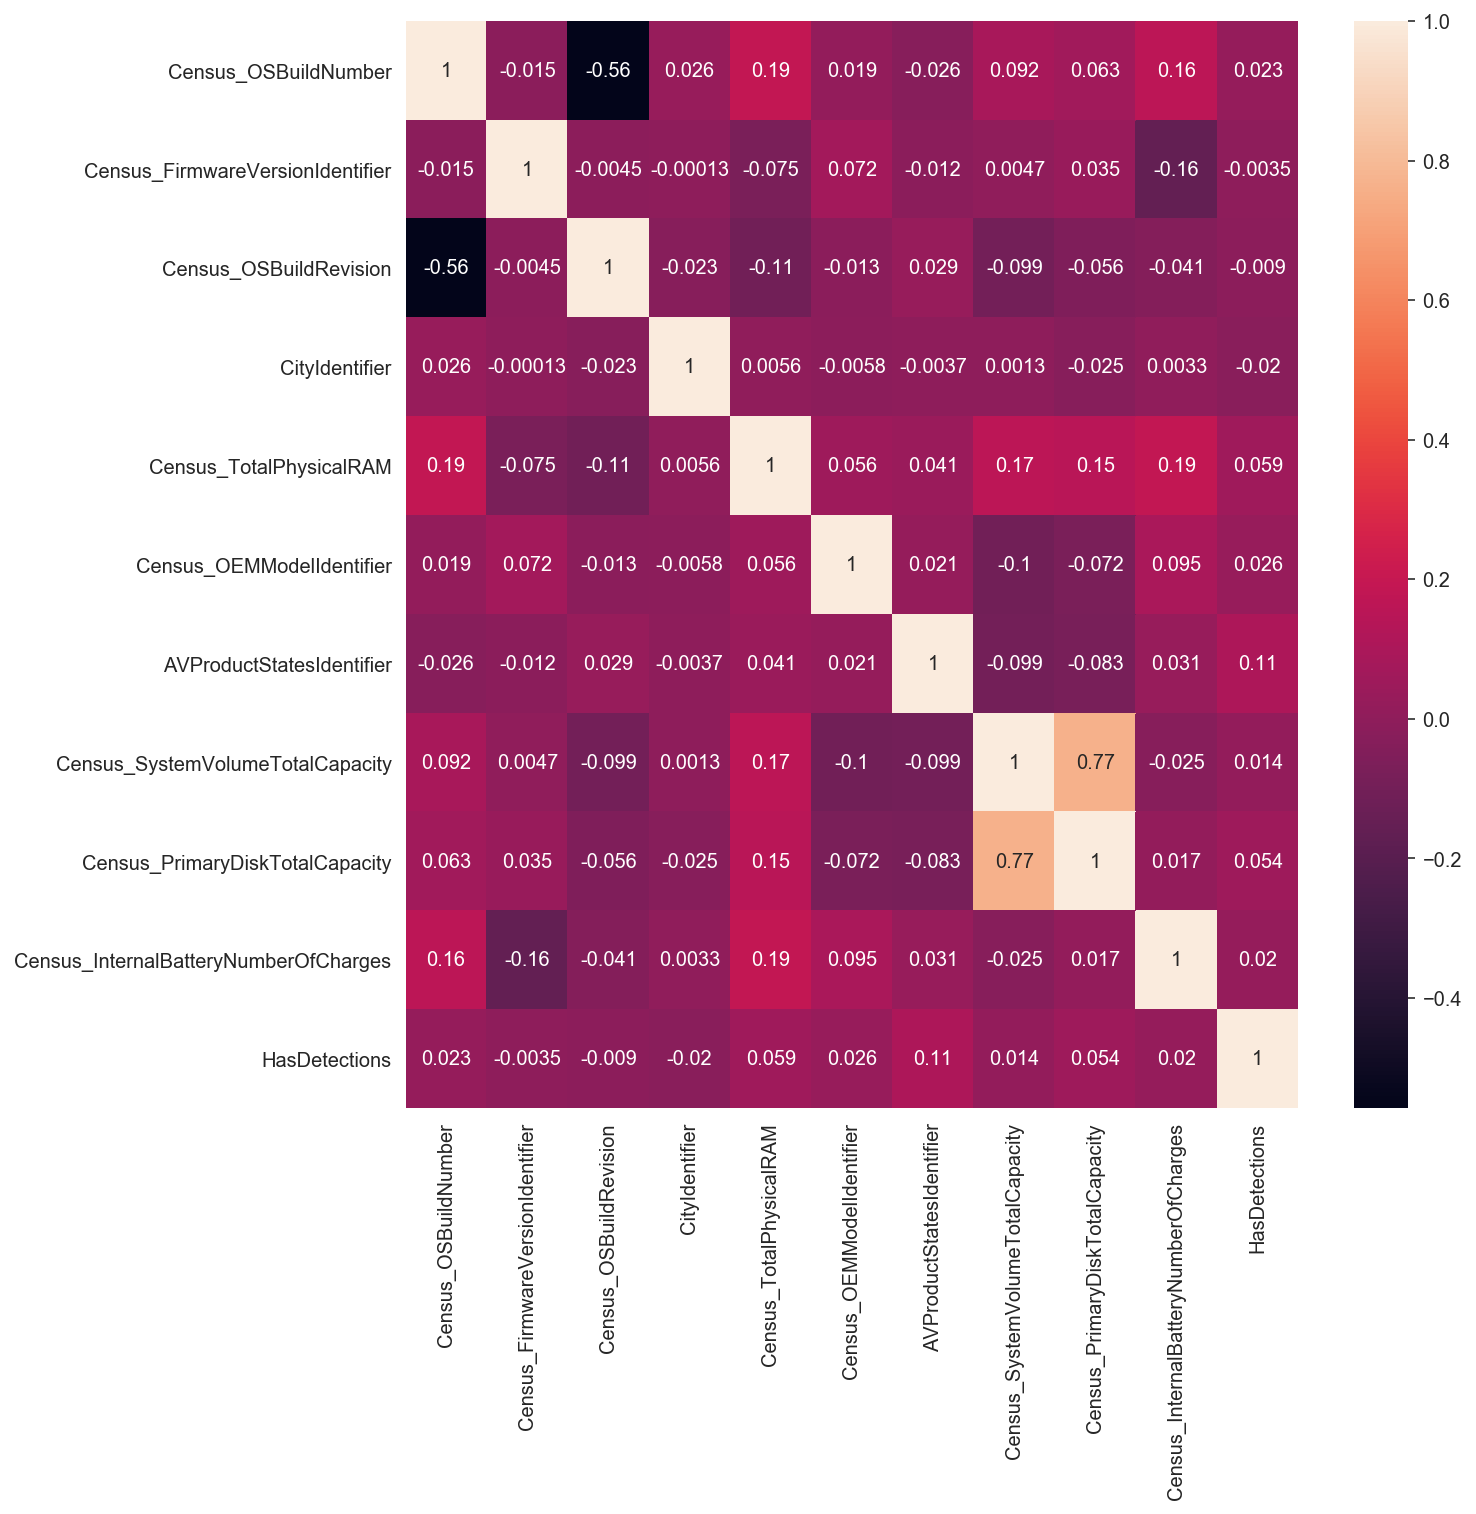

In [36]:
# plot heatmap to see the relationshipe between features and target
S_method=df_[featureScores_2['best_features']]
S_method['HasDetections']=df_['HasDetections']
plt.figure(figsize=(10,10))
sns.heatmap(S_method.corr(), annot=True)
plt.show()

#### - Using RandomForest

In [45]:
# we define 3 functions, each of them do random forest but in different strategies
#1- first one : by using only impotance features 'rf.feature_importances_'
def imp_df(column_names, importances):# send the name of columns and feature_importances_
    data = {
        'Feature': column_names,# save the name of columns
        'Importance': importances,# save the impotances
    }
    
    # create new dataframe that contains two columns ['Feature','Importance']
    # assign 'Feature' as an index
    df = pd.DataFrame(data)\
        .set_index('Feature')\
        .sort_values('Importance', ascending=False)# sort 'Importance' for high prority to low

    return df.head(10) # return the dataframe

X, y = df_.drop(columns=['HasDetections'],axis=1), df_['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)# do split

rf = RandomForestRegressor(n_estimators=10, random_state=0).fit(X_train, y_train)# random forest for X_train and y_train

print('Random Forest Feature Importances:')
RF_Importances=imp_df(X.columns, rf.feature_importances_)# call the first function and print the result
RF_Importances=RF_Importances.sort_values(by='Importance', ascending=True, inplace=False)
RF_Importances

Random Forest Feature Importances:


,Importance
Feature,
GeoNameIdentifier,0.027234
LocaleEnglishNameIdentifier,0.029343
CountryIdentifier,0.029854
Census_InternalPrimaryDiagonalDisplaySizeInInches,0.030365
AVProductStatesIdentifier,0.036290
Census_ProcessorModelIdentifier,0.039995
Census_FirmwareVersionIdentifier,0.044541
Census_OEMModelIdentifier,0.045781
Census_SystemVolumeTotalCapacity,0.053041


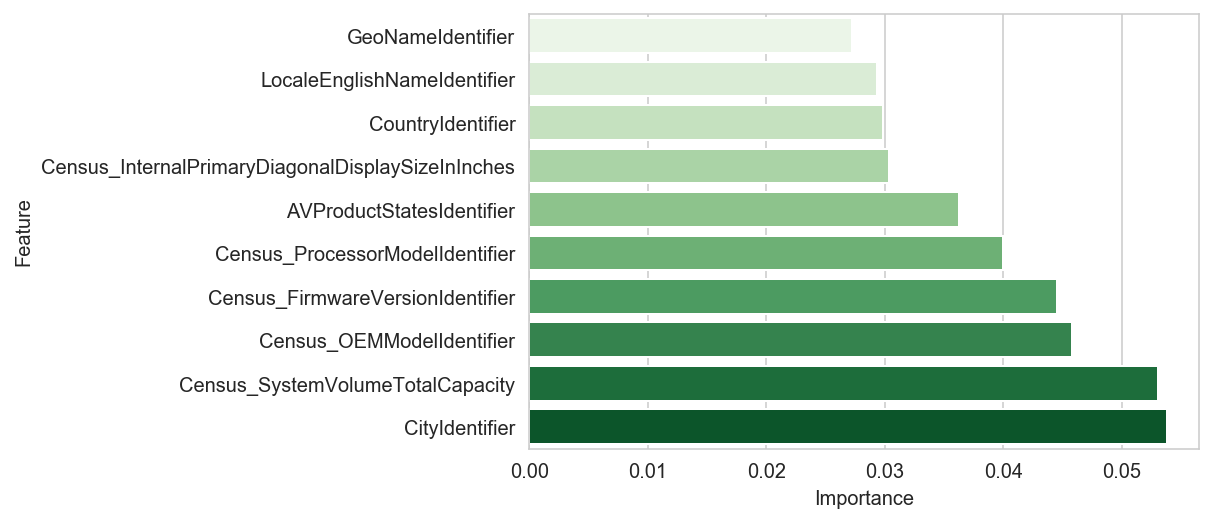

In [46]:
#plot the result 
sns.barplot(x='Importance',y=RF_Importances.index,data=RF_Importances,palette='Greens');

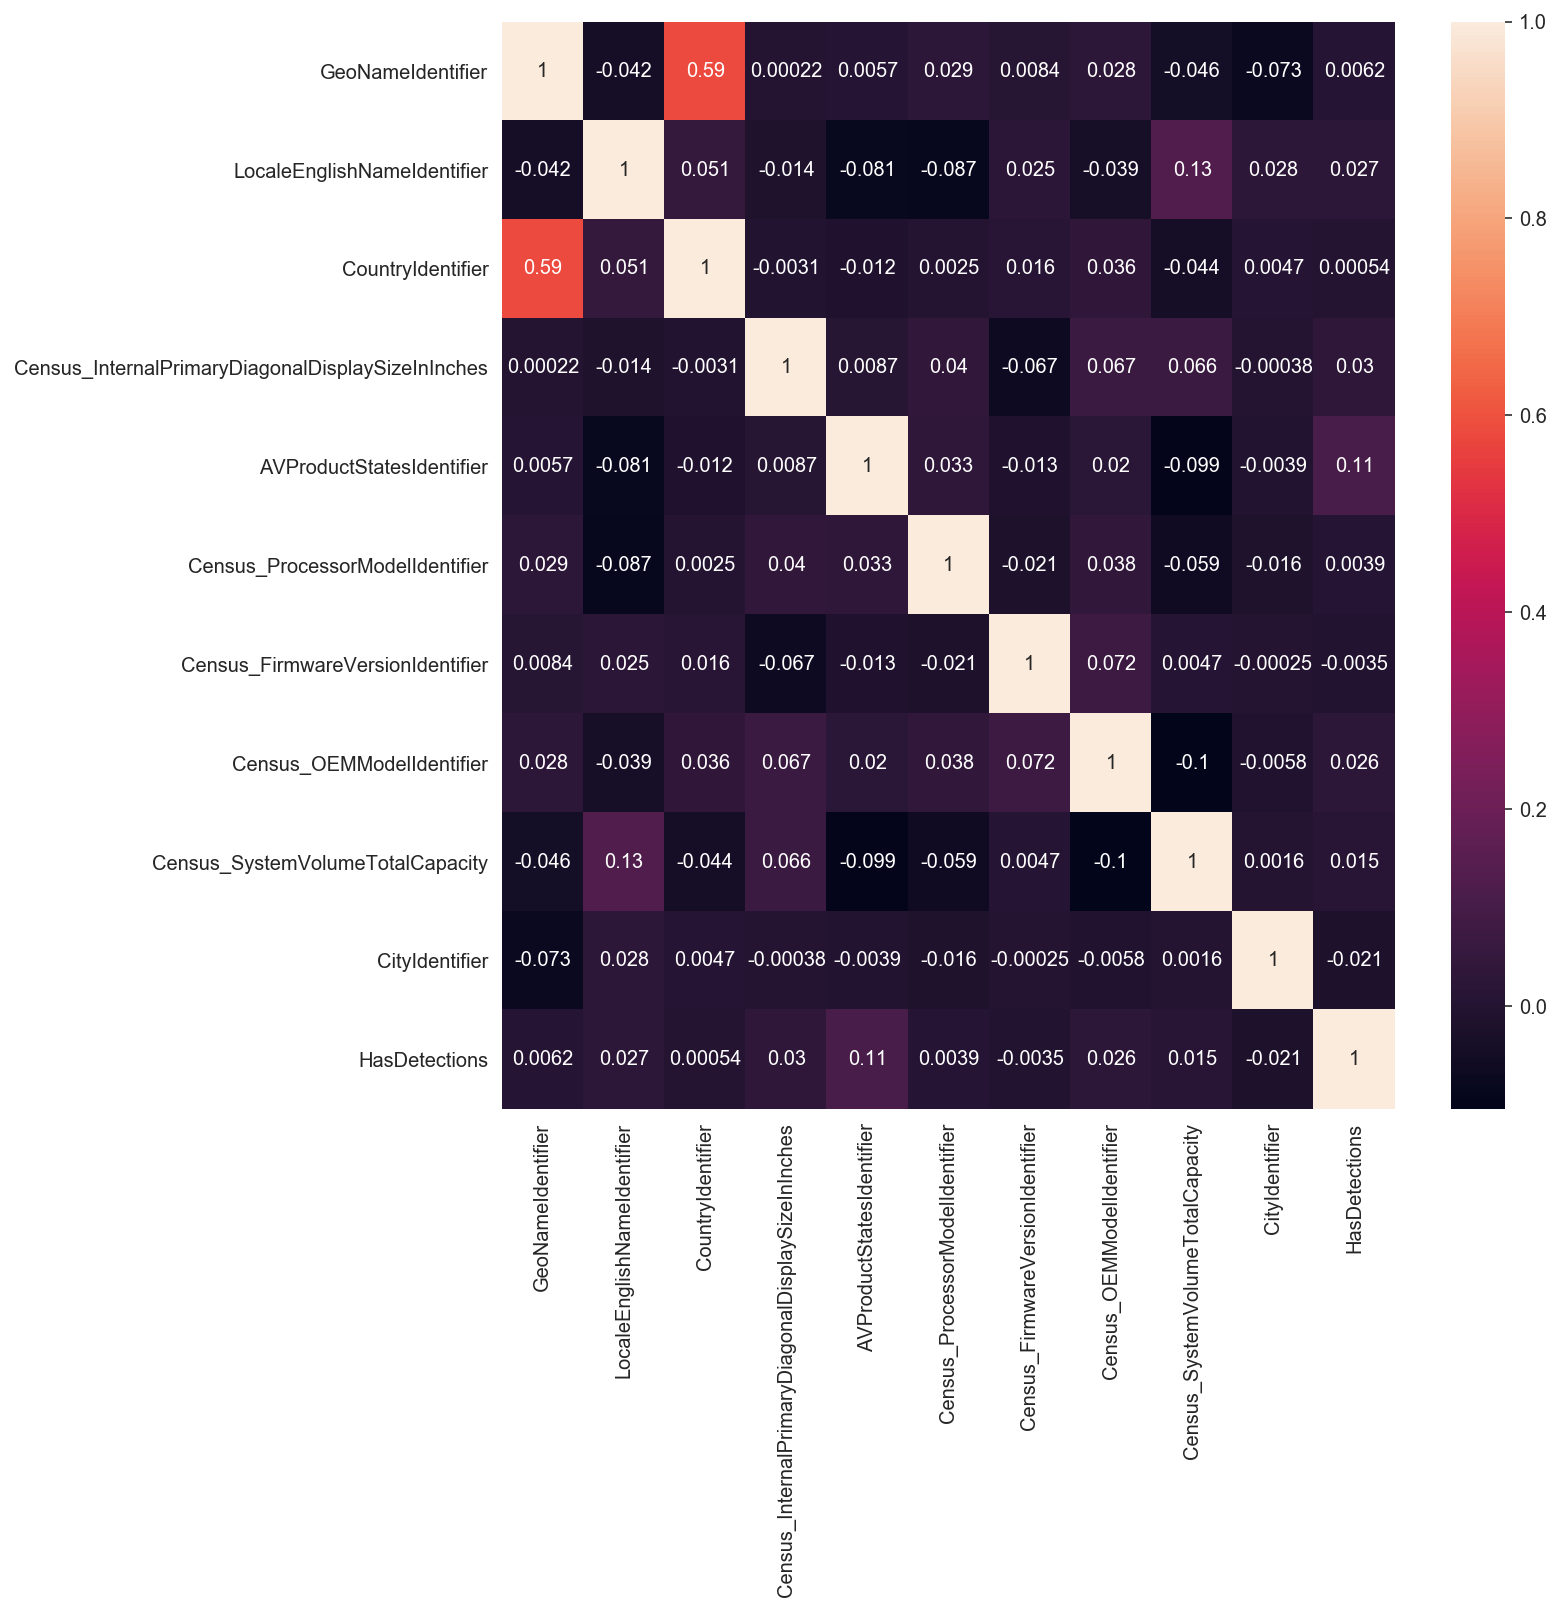

In [47]:
# plot heatmap to see the relationshipe between features and target
Th_method=df[RF_Importances.index]
Th_method['HasDetections']=df['HasDetections']
plt.figure(figsize=(10,10))
sns.heatmap(Th_method.corr(), annot=True)
plt.show()

This method can be the best because most features have positive relationshipe with the target 

## - Modeling
### - LogisticRegression Model
I will apply for all three methods then, I will select the best method to use it in different models
#### First method

In [48]:
X1=df_[featureScores['features']]# assign the features to X1

In [49]:
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y ,test_size=0.2, random_state=0)

In [50]:
# Instantiate pipeline object.
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),#did standerisation to scale the value of features 
    ('logreg', LogisticRegression(solver='liblinear'))# using LogisticRegression model
])

In [51]:
# Define dictionary of hyperparameters.
pipe_params = {'scaler__with_mean': [True, False], 
                 'scaler__with_std': [True, False],
                 'logreg__C': [0.1, 0.2,0.3], 
                 'logreg__fit_intercept': [True, False],
                 'logreg__penalty': ['l1', 'l2']}

In [52]:
# Instantiate our GridSearchCV object.
pipe_gridsearch = GridSearchCV(lr_pipe, # What is the model we want to fit?
                                 pipe_params, # What is the dictionary of hyperparameters?
                                 cv=5, # What number of folds in CV will we use?
                                 verbose=0)

In [53]:
pipe_gridsearch.fit(x1_train, y1_train)# do fit for train data

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'logreg__C': [0.1, 0.2, 0.3],
                         'logreg__fit_intercept': [True, False],
                         'logreg__penalty': ['l1', 'l2'],
                         'scaler__with_mean': [True, False],
                         'scaler__with_std': [True, False]})

In [111]:
score_train=pipe_gridsearch.best_score_#show the best score
print(cl("Logistic_Regression Train",attrs = ['bold']), score_train.round(3))

Logistic_Regression Train 0.564


In [55]:
pipe_gridsearch.best_estimator_#whta is the best pramater that model used??

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(C=0.1, solver='liblinear'))])

In [56]:
pipe_gridsearch_predictions_train = pipe_gridsearch.predict(x1_train)# predicting values in train_data
pipe_gridsearch_predictions_test = pipe_gridsearch.predict(x1_test)# predicting values in test_data

[[1244 2677]
 [ 899 3180]]


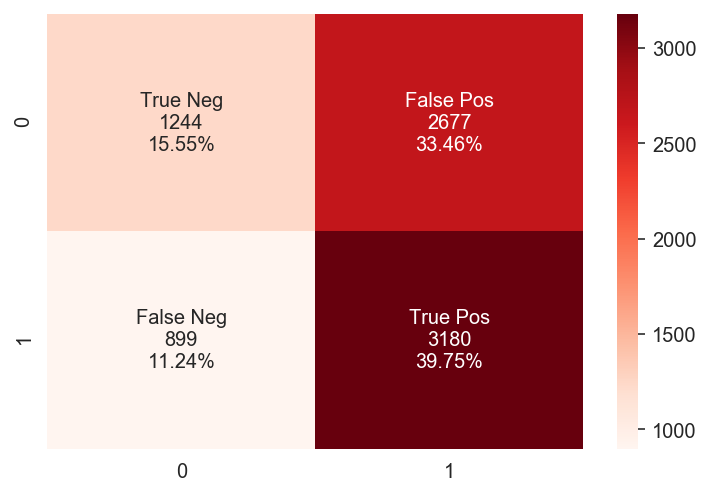

In [101]:
confusion_matrix = metrics.confusion_matrix(y1_train,pipe_gridsearch_predictions_train)#cofusion matrex
print(confusion_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Reds')

In [107]:
print(classification_report(y1_train,pipe_gridsearch_predictions_train))

              precision    recall  f1-score   support

           0       0.58      0.32      0.41      3921
           1       0.54      0.78      0.64      4079

    accuracy                           0.55      8000
   macro avg       0.56      0.55      0.53      8000
weighted avg       0.56      0.55      0.53      8000



In [112]:

preba=pipe_gridsearch.predict_proba(x1_test)
score=pipe_gridsearch.score(x1_test, y1_test)
print(cl("Logistic_Regression Test",attrs = ['bold']), score.round(3))

Logistic_Regression Test 0.503


In [102]:
#plot_confusion_matrix(pipe_gridsearch, x1_test, y1_test)  
#plt.show()

As you see the score of the model not good

#### Second method

In [63]:
X2=df_[featureScores_2['best_features']]# assign the features to X2

In [64]:
x2_train, x2_test, y2_train, y2_test = train_test_split(X2, y ,test_size=0.2, random_state=0)

In [65]:
# Instantiate pipeline object.
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),#did standerisation to scale the value of features 
    ('logreg', LogisticRegression(solver='liblinear'))# using LogisticRegression model
])

In [66]:
# Define dictionary of hyperparameters.
pipe_params = {'scaler__with_mean': [True, False], 
                 'scaler__with_std': [True, False],
                 'logreg__C': [0.1, 0.2,0.3], 
                 'logreg__fit_intercept': [True, False],
                 'logreg__penalty': ['l1', 'l2']}

In [67]:
# Instantiate our GridSearchCV object.
pipe_gridsearch = GridSearchCV(lr_pipe, # What is the model we want to fit?
                                 pipe_params, # What is the dictionary of hyperparameters?
                                 cv=5, # What number of folds in CV will we use?
                                 verbose=0)

In [68]:
pipe_gridsearch.fit(x2_train, y2_train)# do fit for train data

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'logreg__C': [0.1, 0.2, 0.3],
                         'logreg__fit_intercept': [True, False],
                         'logreg__penalty': ['l1', 'l2'],
                         'scaler__with_mean': [True, False],
                         'scaler__with_std': [True, False]})

In [114]:
score_train2=pipe_gridsearch.best_score_#show the best score
print(cl("Logistic_Regression Train",attrs = ['bold']), score_train2.round(3))

Logistic_Regression Train 0.564


In [70]:
pipe_gridsearch.best_estimator_#whta is the best pramater that model used??

Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('logreg', LogisticRegression(C=0.1, solver='liblinear'))])

In [71]:
pipe_gridsearch_predictions_train2 = pipe_gridsearch.predict(x2_train)# predicting values in train_data
pipe_gridsearch_predictions_test2 = pipe_gridsearch.predict(x2_test)# predicting values in test_data

[[1689 2232]
 [1220 2859]]


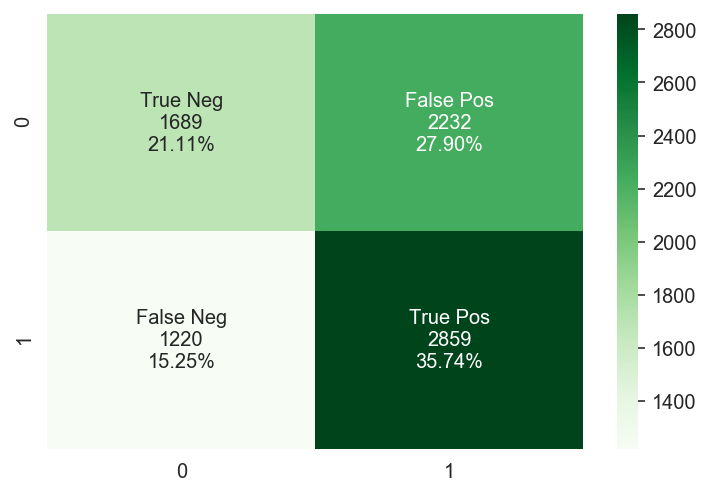

In [100]:
confusion_matrix2 = metrics.confusion_matrix(y2_train,pipe_gridsearch_predictions_train2)#cofusion matrex
print(confusion_matrix2)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix2.flatten()/np.sum(confusion_matrix2)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix2, annot=labels, fmt='', cmap='Greens')

In [106]:
print(classification_report(y2_train,pipe_gridsearch_predictions_train2))

              precision    recall  f1-score   support

           0       0.58      0.43      0.49      3921
           1       0.56      0.70      0.62      4079

    accuracy                           0.57      8000
   macro avg       0.57      0.57      0.56      8000
weighted avg       0.57      0.57      0.56      8000



In [116]:
preba2=pipe_gridsearch.predict_proba(x2_test)# calculate the probability
score2=pipe_gridsearch.score(x2_test, y2_test)# score the test
print(cl("Logistic_Regression Test",attrs = ['bold']), score2.round(3))

Logistic_Regression Test 0.548


In [103]:
#plot_confusion_matrix(pipe_gridsearch, x2_test, y2_test)  
#plt.show()

As you see, still the model doesn't work well but in this method give me slight better

#### Third method

In [75]:
X3=df_[RF_Importances.index]# assign the features to X3

In [76]:
x3_train, x3_test, y3_train, y3_test = train_test_split(X3, y ,test_size=0.2, random_state=0)# Do split

In [78]:
# Instantiate pipeline object.
lr2_pipe = Pipeline([
    ('scaler2', StandardScaler()),#did standerisation to scale the value of features 
    ('logreg2', LogisticRegression(solver='liblinear'))# using LogisticRegression model
])

In [79]:
# Define dictionary of hyperparameters.
pipe2_params = {'scaler2__with_mean': [True, False], 
                 'scaler2__with_std': [True, False],
                 'logreg2__C': [0.1, 0.2,0.3], 
                 'logreg2__fit_intercept': [True, False],
                 'logreg2__penalty': ['l1', 'l2']}

In [80]:
# Instantiate our GridSearchCV object.
pipe2_gridsearch = GridSearchCV(lr2_pipe, # What is the model we want to fit?
                                 pipe2_params, # What is the dictionary of hyperparameters?
                                 cv=5, # What number of folds in CV will we use?
                                 verbose=0)

In [83]:
pipe2_gridsearch.fit(x3_train, y3_train)# do fit for train data

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler2', StandardScaler()),
                                       ('logreg2',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'logreg2__C': [0.1, 0.2, 0.3],
                         'logreg2__fit_intercept': [True, False],
                         'logreg2__penalty': ['l1', 'l2'],
                         'scaler2__with_mean': [True, False],
                         'scaler2__with_std': [True, False]})

In [84]:
pipe2_gridsearch.get_params()# show the parameters that apply

{'cv': 5,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('scaler2', StandardScaler()),
  ('logreg2', LogisticRegression(solver='liblinear'))],
 'estimator__verbose': False,
 'estimator__scaler2': StandardScaler(),
 'estimator__logreg2': LogisticRegression(solver='liblinear'),
 'estimator__scaler2__copy': True,
 'estimator__scaler2__with_mean': True,
 'estimator__scaler2__with_std': True,
 'estimator__logreg2__C': 1.0,
 'estimator__logreg2__class_weight': None,
 'estimator__logreg2__dual': False,
 'estimator__logreg2__fit_intercept': True,
 'estimator__logreg2__intercept_scaling': 1,
 'estimator__logreg2__l1_ratio': None,
 'estimator__logreg2__max_iter': 100,
 'estimator__logreg2__multi_class': 'auto',
 'estimator__logreg2__n_jobs': None,
 'estimator__logreg2__penalty': 'l2',
 'estimator__logreg2__random_state': None,
 'estimator__logreg2__solver': 'liblinear',
 'estimator__logreg2__tol': 0.0001,
 'estimator__logreg2__verbose': 0,
 'estimator__logreg2__warm_star

In [86]:
pipe2_gridsearch.best_estimator_#whta is the best pramater that model used??

Pipeline(steps=[('scaler2', StandardScaler()),
                ('logreg2', LogisticRegression(C=0.1, solver='liblinear'))])

In [88]:
pipe_gridsearch_predictions_train3 = pipe_gridsearch.predict(x3_train)# predicting values in train_data
pipe_gridsearch_predictions_test3= pipe_gridsearch.predict(x3_test)# predicting values in test_data

In [117]:
score_train3=pipe2_gridsearch.best_score_#show the best score
print(cl("Logistic_Regression Train",attrs = ['bold']), score_train3.round(3))

Logistic_Regression Train 0.556


[[ 241 3680]
 [ 132 3947]]


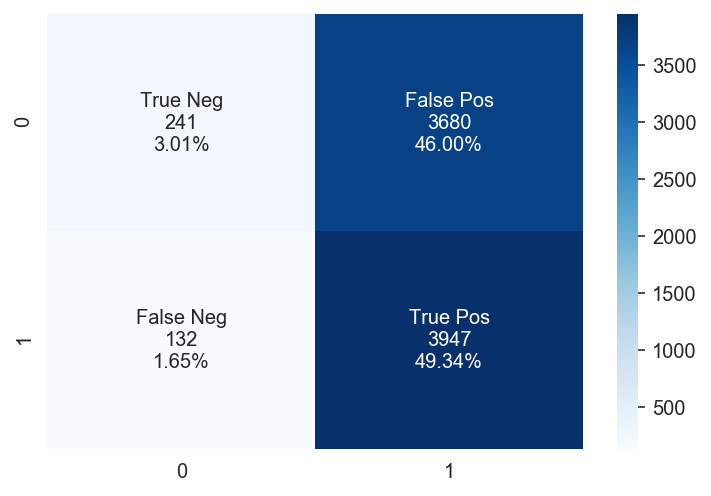

In [108]:
confusion_matrix3 = metrics.confusion_matrix(y3_train,pipe_gridsearch_predictions_train3)#cofusion matrex
print(confusion_matrix3)
#plot_confusion_matrix(pipe_gridsearch, x3_train, y3_train) 
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix3.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix3.flatten()/np.sum(confusion_matrix3)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix3, annot=labels, fmt='', cmap='Blues')

In [109]:
print(classification_report(y3_train,pipe_gridsearch_predictions_train3))

              precision    recall  f1-score   support

           0       0.65      0.06      0.11      3921
           1       0.52      0.97      0.67      4079

    accuracy                           0.52      8000
   macro avg       0.58      0.51      0.39      8000
weighted avg       0.58      0.52      0.40      8000



In [118]:
preba3=pipe2_gridsearch.predict_proba(x3_test)
score3=pipe2_gridsearch.score(x3_test, y3_test)
print(cl("Logistic_Regression Test",attrs = ['bold']), score3.round(3))

Logistic_Regression Test 0.54


In [104]:
#plot_confusion_matrix(pipe_gridsearch, x3_test, y3_test) 